# Song recommendation system 


## Authentication

In [51]:
%config Completer.use_jedi = False
import seaborn as sns
# Data handling libraries
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
## Spotify web api library with functions
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
### Modeling and preprocessing library functions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyOAuth

In [52]:

#client_id = 'd3e1bb20398344068898941764fe4a6c'
#client_id = '06b0e7b8851c4b5aa0a3673195241114'
client_id = '88388dd0052c46518f7ef20bc1b2869f'
#client_secret = '9799462e150f4fc4ba26d8670972cb9e'
#client_secret = 'dc35928c391146989e3409fe1a8d367d'
#client_secret = 'f0ca09ff414c4ab19e530e55a306a33b'
with open('secret.txt',mode='r') as file:
    client_secret = file.read().strip()

redirect_uri = 'http://localhost:8080'
scopes = ['user-library-read', 'playlist-read-private']


sp_oauth = SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri=redirect_uri,
    scope=scopes
)

# Check if a cached token is available,
token_info = sp_oauth.get_cached_token()


if not token_info:
    auth_url = sp_oauth.get_authorize_url()
    print(f'Please visit this URL to authorize the application: {auth_url}')
    response = input('Enter the URL you were redirected to: ')


    code = sp_oauth.parse_response_code(response)
    token_info = sp_oauth.get_access_token(code)


sp = spotipy.Spotify(auth=token_info['access_token'])

user_info = sp.current_user()
print(f'Logged in as {user_info["display_name"]}')


Logged in as Tanmay


## Playlist Track Retrieval 
DataFrame Creation of Preferred Tracks directly from Spotify™

In [53]:
#############DATA SET PREPARATION#####################
####main aim to prepare a dataset for the model####

#playlist_Uri = 'spotify:playlist:53tAcVjUroPk5LA1HV65hZ'
#to store the songs
songs = []

playlists = sp.current_user_playlists()

print('A list of your Playlist is as follows:')

for i,playlist in enumerate(playlists['items']):
    print(f"{i+1}. {playlist['name']}")


idx = int(input('Please select your playlist: '))-1
selection = playlists['items'][idx]
    
selected_uri = selection['uri']

List_of_tracks = sp.user_playlist_tracks(playlist_id=selected_uri)

for music in List_of_tracks['items']:
    song_track = music['track']
    audio_features = sp.audio_features(song_track['uri'])[0]

    songs.append({
        'track_name': music['track']['name'],
        'artist_name': music['track']['artists'][0]['name'],
        'acousticness': audio_features['acousticness'],
        'energy': audio_features['energy'],
        'loudness': audio_features['loudness'],
        'danceability': audio_features['danceability'],
        'valence': audio_features['valence'],
        'liveness': audio_features['liveness'],
        'tempo': audio_features['tempo'],
        #'key': audio_features['key'],
        'duration_ms': audio_features['duration_ms']
        
    })
df = pd.DataFrame(songs)
print(df)
Size = len(df)

A list of your Playlist is as follows:
1. HYPE
2. My recommendation playlist
3. Favorites
4. Gym
5. The Sound of EDM
6. sped up songs
7. 
8. Happy Mix
9. Horizon Pulse - (Forza Horizon 4 Soundtrack)
10. We don’t talk abt this
                                         track_name              artist_name  \
0                                             China                 Anuel AA   
1   Taki Taki (feat. Selena Gomez, Ozuna & Cardi B)                 DJ Snake   
2                                           Bad boy               Marwa Loud   
3                  Can't Hold Us (feat. Ray Dalton)  Macklemore & Ryan Lewis   
4                      haunt you (sped up + reverb)                 X Lovers   
5                    Don't Worry (feat. Ray Dalton)                   Madcon   
6                                   Merci les bleus               KABONGO-DJ   
7                      Ramenez la coupe à la maison                Vegedream   
8                                          Calimero   

## Search Dataset Preparation
Dataset of popular songs of spotify by year for Recommendation

In [54]:
#############DATA SET PREPARATION#####################
#preparing that dataframe
"""
extract = pd.read_csv('Recommendation.csv')
#specific indices that i want:
#colums are song,artist,acoust,energ,loudne,danceab,valence,liveness,tempo,key,duration
column_indices = [3,7,16,11,13,10,19,18,20,12,21]
#iloc to locate
recommend = extract.iloc[:,column_indices]
print(recommend)
"""
extract = pd.read_csv('spotify_dataset.csv')
#specific indices that i want:
#colums are song,artist,acoust,energ,loudne,danceab,valence,liveness,tempo,duration
#iloc to locate
column_indices = [0,1,2,3,4,5,6,7,8,9]
recommend = extract.iloc[:,column_indices]
print(recommend)

                               Song Name                         Artist  \
0                                Beggin'                       Måneskin   
1              STAY (with Justin Bieber)                  The Kid LAROI   
2                               good 4 u                 Olivia Rodrigo   
3                             Bad Habits                     Ed Sheeran   
4      INDUSTRY BABY (feat. Jack Harlow)                      Lil Nas X   
...                                  ...                            ...   
1551                           New Rules                       Dua Lipa   
1552                  Cheirosa - Ao Vivo                 Jorge & Mateus   
1553           Havana (feat. Young Thug)                 Camila Cabello   
1554          Surtada - Remix Brega Funk  Dadá Boladão, Tati Zaqui, OIK   
1555  Lover (Remix) [feat. Shawn Mendes]                   Taylor Swift   

     Acousticness Energy Loudness Danceability Valence Liveness    Tempo  \
0           0.127    0.

## Encoding of the labels of artist name and song name

In [55]:
#############DATA SET NORMALIZATION AND VECTORIZATION#####################

#References : https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/#
"""
encde = LabelEncoder()

df.iloc[:,0] = encde.fit_transform(df.iloc[:,0])
df.iloc[:,1] = encde.fit_transform(df.iloc[:,1])

recommend.iloc[:,0] = encde.fit_transform(recommend.iloc[:,0])
recommend.iloc[:,1] = encde.fit_transform(recommend.iloc[:,1])
"""
#References : https://www.youtube.com/watch?v=DIxxz_DvqLA -- for TfidVectorizer implementation
#           : https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/ -- for norm-
#           : alisation
vectorizer = TfidfVectorizer()
Text_Matrix_Vectorized = vectorizer.fit_transform(df['track_name'] + ' ' + df['artist_name'])

vectorizer1 = TfidfVectorizer()
Text_Matrix_Vectorized_rec = vectorizer1.fit_transform(recommend['Song Name'] + ' ' + recommend['Artist'])

playlist_features_normalized = df[['acousticness', 'energy','loudness', 'danceability', 'valence', 'liveness', 'tempo', 'duration_ms']] #key removed
standardizer = StandardScaler()
playlist_features_normalized = standardizer.fit_transform(playlist_features_normalized)

playlist_features_normalized = pd.DataFrame(playlist_features_normalized).fillna(0).values


dataset_features_normalized = recommend[['Acousticness', 'Energy','Loudness', 'Danceability', 'Valence', 'Liveness', 'Tempo', 'Duration (ms)']] #key removed

for col in ['Acousticness', 'Energy', 'Loudness', 'Danceability', 'Valence', 'Liveness', 'Tempo', 'Duration (ms)']:
    dataset_features_normalized[col] = pd.to_numeric(dataset_features_normalized[col], errors='coerce')

# Fill missing values with the mean of each column
dataset_features_normalized = dataset_features_normalized.fillna(dataset_features_normalized.mean())

# Standardize the numeric features
standardizer1 = StandardScaler()
dataset_features_normalized = standardizer1.fit_transform(dataset_features_normalized)


/var/folders/6d/rkmmbh6918g_yt4557gdwly00000gn/T/ipykernel_50021/2658875533.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_features_normalized[col] = pd.to_numeric(dataset_features_normalized[col], errors='coerce')


## Content Based Filtering

In [56]:
#############CONTENT BASED FILTERING#####################
cosine_text = cosine_similarity(Text_Matrix_Vectorized,Text_Matrix_Vectorized)
#cosine_text_rec =  cosine_similarity(Text_Matrix_Vectorized_rec,Text_Matrix_Vectorized_rec)

cosine_att = cosine_similarity(playlist_features_normalized,playlist_features_normalized)
#cosine_att_rec = cosine_similarity(dataset_features_normalized, dataset_features_normalized)

In [57]:
#############PREPARING A LIST#####################
text_weight = 0.5
attribute_weight = 0.5

N=10

mega_list = []

for user_song_index in range(Size):

    weighted_similarity = (text_weight * cosine_text[user_song_index]) + (attribute_weight * cosine_att[user_song_index])


    top_rec_indices = np.argsort(-np.array(weighted_similarity))[:N]


    user_song_name = df['track_name'].iloc[user_song_index]
    rec_song_names = [recommend['Song Name'].iloc[rec_index] for rec_index in top_rec_indices]

    for i, rec_song_name in enumerate(rec_song_names):
        mega_list.append((rec_song_name))
        

song_counter = Counter(mega_list)

top10 = song_counter.most_common(10)

i=0
for item,occurance in top10:
    i+=1
    print(f"{i}.",item)



1. STAY (with Justin Bieber)
2. Beggin'
3. Volando - Remix
4. Kiss Me More (feat. SZA)
5. Bad Habits
6. Todo De Ti
7. MONTERO (Call Me By Your Name)
8. deja vu
9. Levitating (feat. DaBaby)
10. Butter


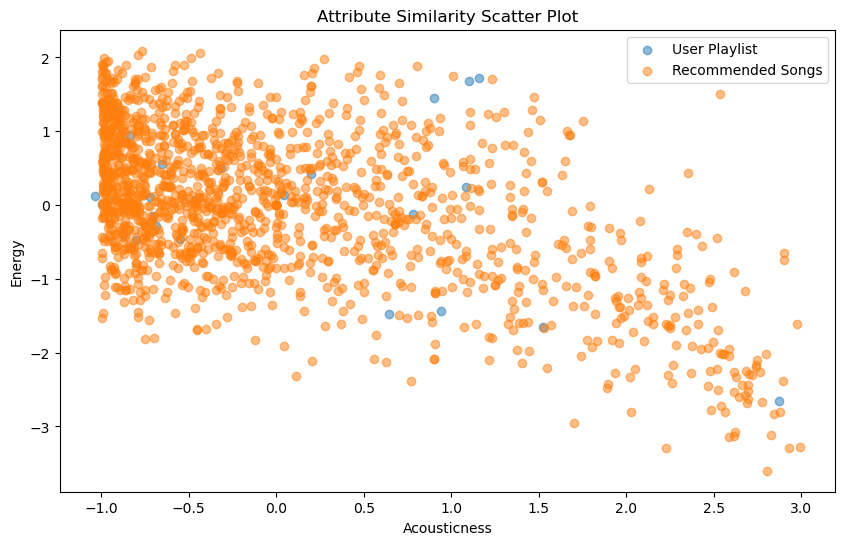

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(playlist_features_normalized[:, 0], playlist_features_normalized[:, 1], label='User Playlist', alpha=0.5)
plt.scatter(dataset_features_normalized[:, 0], dataset_features_normalized[:, 1], label='Recommended Songs', alpha=0.5)
plt.xlabel('Acousticness')
plt.ylabel('Energy')
plt.title('Attribute Similarity Scatter Plot')
plt.legend()
plt.show()


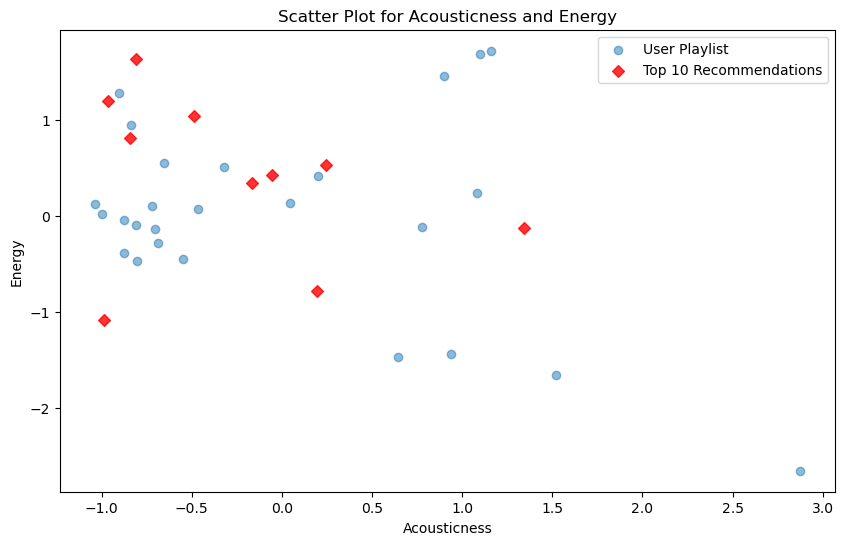

In [59]:
top10_recommendations = [item[0] for item in top10]
top10_recommendation_indices = [recommend.index[recommend['Song Name'] == song].tolist()[0] for song in top10_recommendations]
top10_recommendation_features = dataset_features_normalized[top10_recommendation_indices]

# Scatter plot for Acousticness and Energy
plt.figure(figsize=(10, 6))
plt.scatter(playlist_features_normalized[:, 0], playlist_features_normalized[:, 1], label='User Playlist', alpha=0.5)
plt.scatter(top10_recommendation_features[:, 0], top10_recommendation_features[:, 1], label='Top 10 Recommendations', alpha=0.8, marker='D', color='red')
plt.xlabel('Acousticness')
plt.ylabel('Energy')
plt.title('Scatter Plot for Acousticness and Energy')
plt.legend()
plt.show()

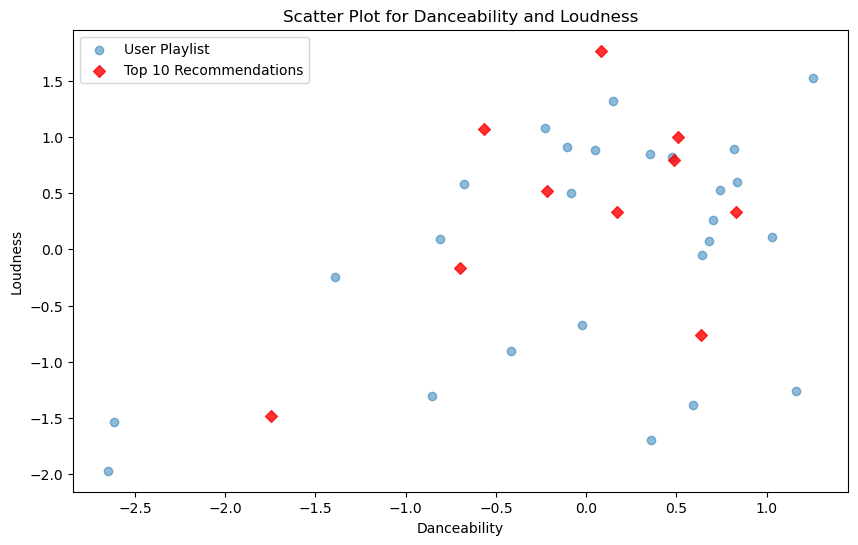

In [60]:
# Scatter plot for Danceability and Loudness
plt.figure(figsize=(10, 6))
plt.scatter(playlist_features_normalized[:, 3], playlist_features_normalized[:, 4], label='User Playlist', alpha=0.5)
plt.scatter(top10_recommendation_features[:, 3], top10_recommendation_features[:, 4], label='Top 10 Recommendations', alpha=0.8, marker='D', color='red')
plt.xlabel('Danceability')
plt.ylabel('Loudness')
plt.title('Scatter Plot for Danceability and Loudness')
plt.legend()
plt.show()


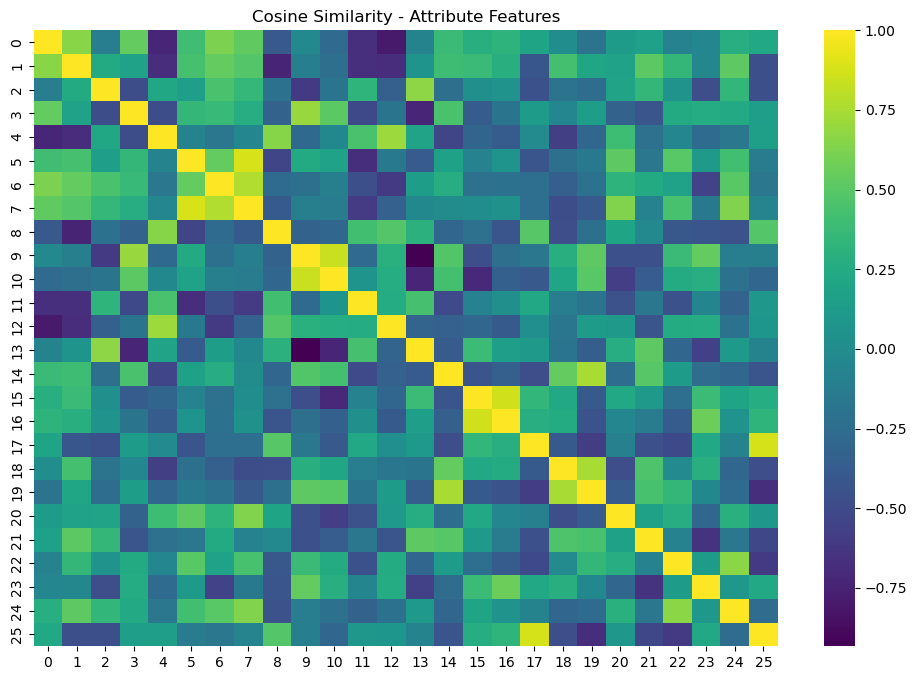

In [61]:
plt.figure(figsize=(12, 8))
sns.heatmap(cosine_att, cmap='viridis', annot=False)
plt.title('Cosine Similarity - Attribute Features')
plt.show()


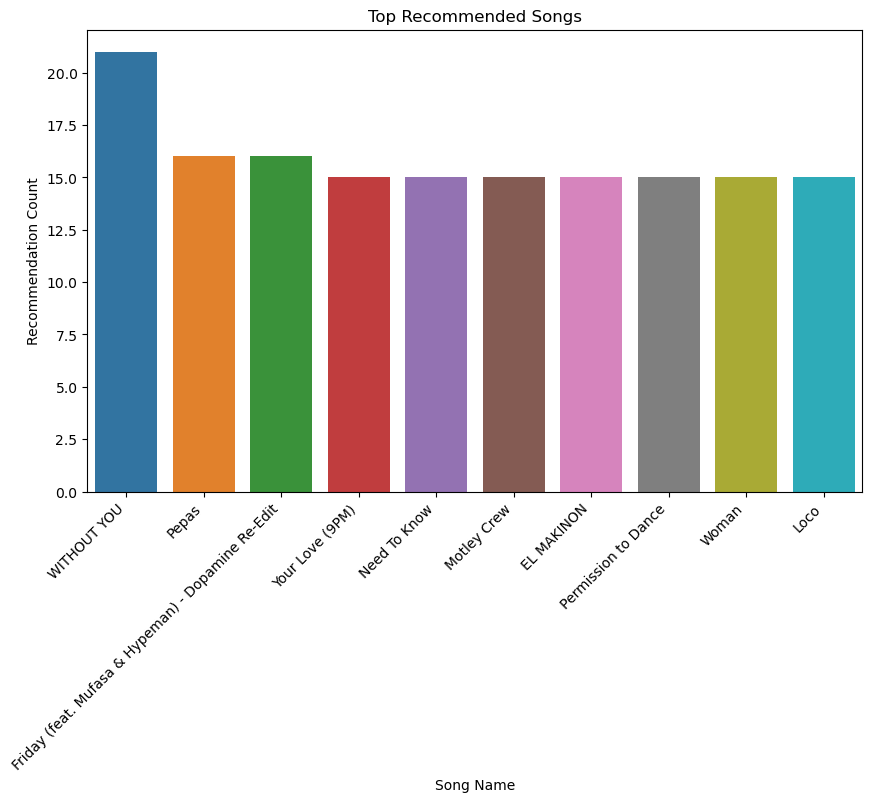

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[item[0] for item in top10], y=[item[1] for item in top10])
plt.xlabel('Song Name')
plt.ylabel('Recommendation Count')
plt.title('Top Recommended Songs')
plt.xticks(rotation=45, ha='right')
plt.show()
